# Data analysis and figures for the IRimage paper

## Part 2: Example use case (Figs. 3, 4, and S2)

Gustavo Pereyra Irujo


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams["legend.loc"] = 'best'
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.labelsize"] = 12


## 1. Temperature calculation - fixed parameters

### 1.1. Mean air temperature and relative humidity from the weather sensor data

In [2]:
# read csv file with environmental data
path = '../environmental_data/EM24072_10Dec19-1724.csv'
environmental_data = pd.read_csv(path, parse_dates=['Date_Time'])

In [3]:
# crop environmetal data table to match the timestamps of the images
first_image_datetime = pd.to_datetime('2019-12-09 16:13:39')
last_image_datetime  = pd.to_datetime('2019-12-10 16:16:22')
environmental_data = environmental_data.loc[(environmental_data['Date_Time'] > first_image_datetime) & (environmental_data['Date_Time'] < last_image_datetime)]

In [4]:
mean_rh = environmental_data['RH'].mean()
mean_temp = environmental_data['Temp'].mean()

print('Mean air temperature:', mean_temp)
print('Mean air relative humidity:', mean_rh)

Mean air temperature: 30.845807345807344
Mean air relative humidity: 0.4521067221067221


### 1.1. Mean reflected apparent temperature from reflective reference

The reflected apparent temperature is estimated by measuring the temperature of a reflective reference made from a piece of aluminium paper, placed in the field of view of the camera, in images processed with an emissivity value of 1. 

First all images were copied to a folder named "measurements_reflective_reference_fixed_param" and were processed using the "Set global parameters..." option, setting emissivity to 1, air temperature and humidity to the values determined previously (30.8°C and 45%), and object distance to 4m (the value of reflected temperature does not affect the calculated temperature when emissivity is 1). 

Then, the "Measure" function was used to select and measure the temperature of the reflective reference.

In [5]:
# read measurements of apparent temperature of the reflective reference
path = '../measurements_reflective_reference_fixed_param/results/measurements_reflective_reference.csv'
reference_measurements = pd.read_csv(path, parse_dates=[['Date', 'Time']], index_col=" ")

<AxesSubplot:xlabel='Date_Time'>

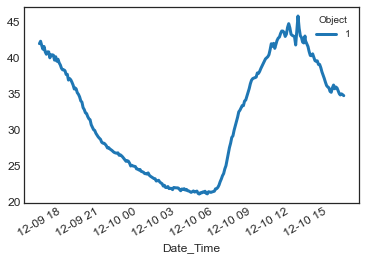

In [6]:
reference_mean_temp = reference_measurements.pivot('Date_Time', 'Object', 'Obj_mean_temp')
reference_mean_temp.columns = reference_mean_temp.columns.astype('string')
reference_mean_temp.plot()

In [7]:
mean_app_refl_temp = reference_measurements['Obj_mean_temp'].mean()

print('Mean apparent reflected temperature:', mean_app_refl_temp)

Mean apparent reflected temperature: 32.01540890688259


### 1.3. Leaf temperature measurement data - fixed parameters

Then, images were copied again to a folder named "measurements_leaves_fixed_param" and processed again, using the "Set global parameters..." option with an emissivity value for plant leaves (0.95) and the mean reflected apparent temperature determined previously (32.0°C)

The "Measure" function was used together with a previously created mask image for the leaves of each plant (leaves.tif).

In [8]:
path = '../measurements_leaves_fixed_param/results/measurements_leaves.csv'
fixed_param_measurements = pd.read_csv(path, parse_dates=[['Date', 'Time']], index_col=" ")

<AxesSubplot:xlabel='Date_Time'>

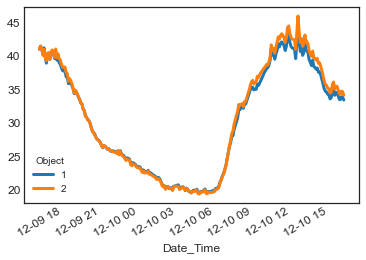

In [9]:
fixed_param_mean_temp = fixed_param_measurements.pivot('Date_Time', 'Object', 'Obj_mean_temp')
fixed_param_mean_temp.columns = fixed_param_mean_temp.columns.astype('string')
fixed_param_mean_temp.plot()

## 2. Temperature calculations - variable parameters

### 2.1. Input table with parameters for each image

In order to process each image, it is necessary to create an input table with the parameter values for each image. To do that, the parameter table that was generated when the images was process using fixed parameters is taken and modified accordingly. 

In that table, the fixed values for air temperature and humidity are replaced by the corresponding values measured by the weather sensor, at the time nearest to the time the image was captured. The fixed value for the apparent reflected temperature is replaced by the apparent reflected temperature estimated from each image.

In [10]:
# read parameters table used previously
path = '../measurements_leaves_fixed_param/results/parameters.csv'
parameters_table = pd.read_csv(path, index_col=" ")

In [11]:
# build a table combining the parameter data, reflected temperature data, and environmental data
combined_table = parameters_table.copy()
combined_table = combined_table.merge(reference_measurements, how='left', on='Image')
combined_table = pd.merge_asof(combined_table, environmental_data, on='Date_Time', direction='nearest')

In [12]:
# modify the table using the measured data
parameters_table.reset_index(drop=True, inplace=True)
parameters_table['App_refl_temp'] = combined_table['Obj_mean_temp']
parameters_table['Air_temp'] = combined_table['Temp']
parameters_table['Air_rel_hum'] = combined_table['RH']
parameters_table.to_csv('../variable_parameters_tables/variable_parameters_table_0_95.csv', index=False)


### 2.2. Leaf temperature measurements data - variable parameters

In this case, images were placed in a folder named "measurements_leaves_variable_param" and processed using the "Use parameters from file" option, selecting the table created in the previous step.

The "Measure" function was used together with the same mask image used previously for measuring the leaves of each plant (leaves.tif).


In [13]:
path = '../measurements_leaves_variable_param/results/measurements_leaves.csv'
variable_param_measurements = pd.read_csv(path, parse_dates=[['Date', 'Time']], index_col=" ")

<AxesSubplot:xlabel='Date_Time'>

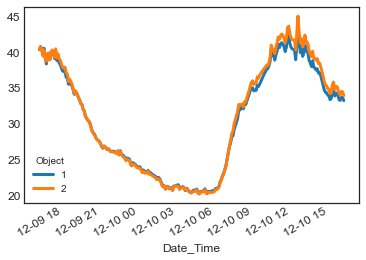

In [14]:
variable_param_mean_temp = variable_param_measurements.pivot('Date_Time', 'Object', 'Obj_mean_temp')
variable_param_mean_temp.columns = variable_param_mean_temp.columns.astype('string')
variable_param_mean_temp.plot()

## 3. Comparison between methods

<AxesSubplot:xlabel='Date_Time'>

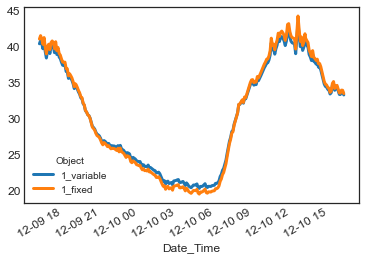

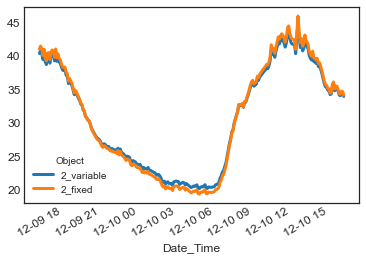

In [15]:
method_comparison = variable_param_mean_temp.join(fixed_param_mean_temp, lsuffix='_variable', rsuffix='_fixed')
method_comparison[['1_variable', '1_fixed']].plot()
method_comparison[['2_variable', '2_fixed']].plot()

## 4. Leaf-to-air temperature differences

<AxesSubplot:>

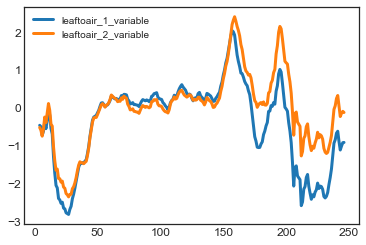

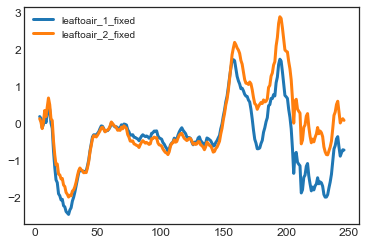

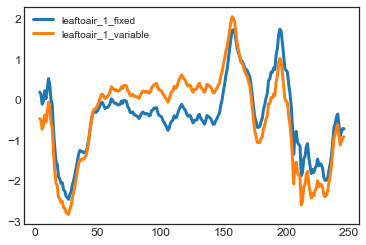

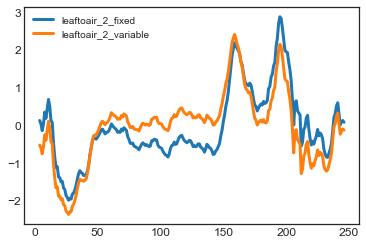

In [16]:
# build a table combining leaf temperature and environmental data
combined_table = method_comparison.copy()
combined_table = pd.merge_asof(combined_table, environmental_data, on='Date_Time', direction='nearest')

# calculate leaf-to-air temperature differences
combined_table['leaftoair_1_fixed'] = combined_table['1_fixed'] - combined_table['Temp']
combined_table['leaftoair_1_variable'] = combined_table['1_variable'] - combined_table['Temp']
combined_table['leaftoair_2_fixed'] = combined_table['2_fixed'] - combined_table['Temp']
combined_table['leaftoair_2_variable'] = combined_table['2_variable'] - combined_table['Temp']

# plot data
combined_table[['leaftoair_1_variable', 'leaftoair_2_variable']].rolling(5).mean().plot()
combined_table[['leaftoair_1_fixed', 'leaftoair_2_fixed']].rolling(5).mean().plot()
combined_table[['leaftoair_1_fixed', 'leaftoair_1_variable']].rolling(5).mean().plot()
combined_table[['leaftoair_2_fixed', 'leaftoair_2_variable']].rolling(5).mean().plot()

## 5. Temperature of the sensor enclosure

As a control, the temperature of the enclosure of the weather sensor was also measured using the thermal images. In this case, the emissivity value used was 0.84 (literature value for white paint). A new table with variable parameters was generated, replacing only the emissivity values.

Then the images were placed in a folder named "measurements_sensor_enclosure" and processed using the parameters from this file.

finally, the "Measure" function was used to select and measure the pixels correspondin to the sensor enclosure.

In [17]:
parameters_table_temp_sensor = parameters_table.copy()
parameters_table_temp_sensor['Obj_emissivity'] = 0.84
parameters_table_temp_sensor.to_csv('../variable_parameters_tables/variable_parameters_table_0_84.csv', index=False)

In [18]:
path = '../measurements_sensor_enclosure/results/measurements_sensor_enclosure.csv'
temp_sensor_measurements = pd.read_csv(path, parse_dates=[['Date', 'Time']], index_col=" ")

In [19]:
temp_sensor_measurements.reset_index(drop=True, inplace=True)
temp_sensor_measurements['thermography_data'] = temp_sensor_measurements['Obj_mean_temp']
temp_sensor_measurements['sensor_data'] = combined_table['Temp']

<AxesSubplot:>

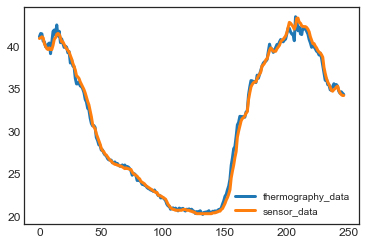

In [20]:
temp_sensor_measurements[['thermography_data', 'sensor_data']].plot()

## 6. Figures

Figures for the IRimage paper using the generated data

### 6.1. Figure 3: Environmental conditions in the greenhouse during the experiment

In [21]:
# find the sunset and sunrise times

night_hours = environmental_data.loc[environmental_data['PAR']<2, 'Date_Time'].reset_index(drop=True)
sunset=night_hours[0]
sunrise=night_hours[len(night_hours)-1]

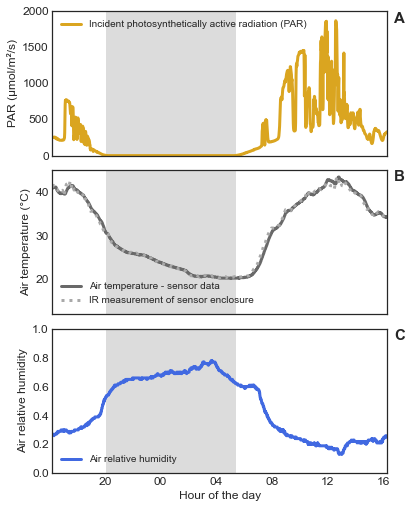

In [22]:
fig = plt.figure(figsize=(6,8.5))
gs = fig.add_gridspec(3, hspace=0.1)
axs = gs.subplots(sharex=True)
plt.xlim(first_image_datetime, last_image_datetime)

axs[0].set_title('A', x=1.02, y=0.88, ha='left', fontsize=15, fontweight='bold')
axs[0].plot(environmental_data['Date_Time'], environmental_data['PAR'], 'goldenrod', label='Incident photosynthetically active radiation (PAR)')
axs[0].set_ylim([0,2000])
axs[0].set_ylabel('PAR (μmol/m²/s)')
axs[0].legend(loc='upper left')

axs[1].set_title('B', x=1.02, y=0.88, ha='left', fontsize=15, fontweight='bold')
axs[1].plot(environmental_data['Date_Time'], environmental_data['Temp'], 'dimgrey', label='Air temperature - sensor data')
axs[1].plot(temp_sensor_measurements['Date_Time'], temp_sensor_measurements['thermography_data'], 'darkgrey', linestyle=':', label='IR measurement of sensor enclosure')
axs[1].set_ylim([12,45])
axs[1].set_ylabel('Air temperature (°C)')
axs[1].legend(loc='lower left')

axs[2].set_title('C', x=1.02, y=0.88, ha='left', fontsize=15, fontweight='bold')
axs[2].plot(environmental_data['Date_Time'], environmental_data['RH'], 'royalblue', label='Air relative humidity')
axs[2].set_ylim([0.0,1.0])
axs[2].set_ylabel('Air relative humidity')
axs[2].legend(loc='lower left')

axs[2].set_xlabel('Hour of the day')
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
axs[2].xaxis.set_major_locator(mdates.HourLocator(interval=4))


for ax in axs:
    ax.fill_between([sunrise,sunset], [-10000,-10000], [10000,10000], facecolor='gainsboro')

plt.savefig('../../figures/Figure_3.png', bbox_inches = 'tight', pad_inches = 0.1, dpi=240)

### 6.2. Figure 4: Leaf temperature of well-watered and water-stressed plants

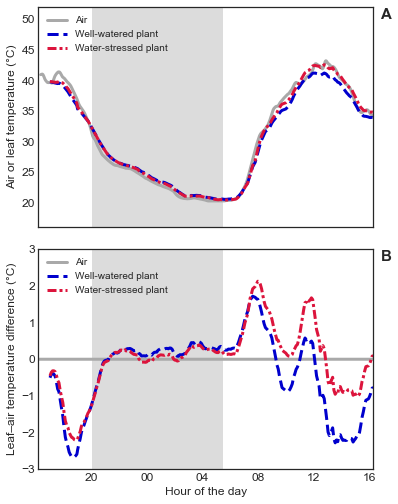

In [23]:
fig = plt.figure(figsize=(6,8.5))
gs = fig.add_gridspec(2, hspace=0.1)
axs = gs.subplots(sharex=True)
plt.xlim(first_image_datetime, last_image_datetime)

axs[0].set_title('A', x=1.055, y=0.92, ha='right', fontsize=15, fontweight='bold')
axs[0].plot(environmental_data['Date_Time'], environmental_data['Temp'].rolling(10).mean(), color='darkgray', linestyle='-', label='Air')
axs[0].plot(variable_param_mean_temp.index, variable_param_mean_temp['1'].rolling(10).mean(), color='mediumblue', linestyle='--', label='Well-watered plant')
axs[0].plot(variable_param_mean_temp.index, variable_param_mean_temp['2'].rolling(10).mean(), color='crimson', linestyle=(0, (3, 1, 1, 1)), label='Water-stressed plant')
axs[0].set_ylim([16,52])
axs[0].set_ylabel('Air or leaf temperature (°C)')

axs[1].set_title('B', x=1.055, y=0.92, ha='right', fontsize=15, fontweight='bold')
axs[1].plot(environmental_data['Date_Time'], [0]*len(environmental_data['Temp']), color='darkgray', linestyle='-', label='Air')
axs[1].plot(combined_table['Date_Time'], combined_table['leaftoair_1_variable'].rolling(10).mean(), color='mediumblue', linestyle='--', label='Well-watered plant')
axs[1].plot(combined_table['Date_Time'], combined_table['leaftoair_2_variable'].rolling(10).mean(), color='crimson', linestyle=(0, (3, 1, 1, 1)), label='Water-stressed plant')
axs[1].set_ylim([-3,+3])
axs[1].set_ylabel('Leaf–air temperature difference (°C)')

axs[0].legend(loc='upper left')
axs[1].legend(loc='upper left')

axs[1].set_xlabel('Hour of the day')
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
axs[1].xaxis.set_major_locator(mdates.HourLocator(interval=4))

for ax in axs:
    ax.fill_between([sunrise,sunset], [-10000,-10000], [10000,10000], facecolor='gainsboro')
    
plt.savefig('../../figures/Figure_4.png', bbox_inches = 'tight', pad_inches = 0.1, dpi=240)

### 6.3. Figure S2: Comparison of leaf temperature values obtained with either fixed parameters or variable parameters

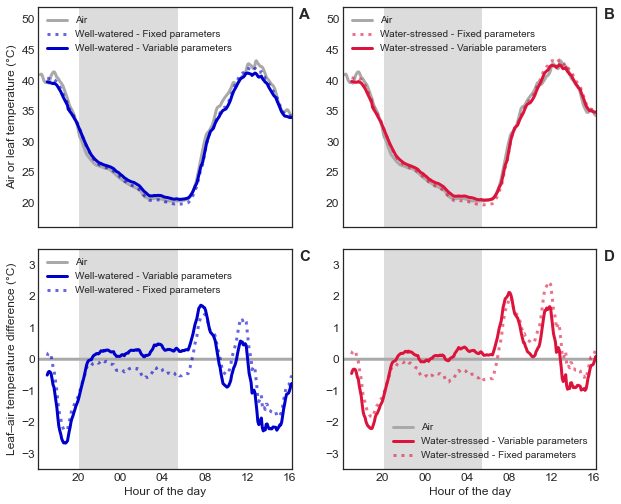

In [24]:
fig = plt.figure(figsize=(10,8.5))
gs = fig.add_gridspec(2,2, hspace=0.1)
axs = gs.subplots(sharex=True)
plt.xlim(first_image_datetime, last_image_datetime)


axs[0,0].set_title('A', x=1.07, y=0.92, ha='right', fontsize=15, fontweight='bold')
axs[0,0].plot(environmental_data['Date_Time'], environmental_data['Temp'].rolling(10).mean(), '-', color='darkgray', label='Air')
axs[0,0].plot(method_comparison.index, method_comparison['1_fixed'].rolling(10).mean(), ':', color='mediumblue', label='Well-watered - Fixed parameters', alpha=0.6)
axs[0,0].plot(method_comparison.index, method_comparison['1_variable'].rolling(10).mean(), '-', color='mediumblue', label='Well-watered - Variable parameters')
axs[0,0].set_ylim([16,52])
axs[0,0].set_ylabel('Air or leaf temperature (°C)')

axs[0,1].set_title('B', x=1.07, y=0.92, ha='right', fontsize=15, fontweight='bold')
axs[0,1].plot(environmental_data['Date_Time'], environmental_data['Temp'].rolling(10).mean(), '-', color='darkgray', label='Air')
axs[0,1].plot(method_comparison.index, method_comparison['2_fixed'].rolling(10).mean(), ':', color='crimson', label='Water-stressed - Fixed parameters', alpha=0.6)
axs[0,1].plot(method_comparison.index, method_comparison['2_variable'].rolling(10).mean(), '-', color='crimson', label='Water-stressed - Variable parameters')
axs[0,1].set_ylim([16,52])


axs[1,0].set_title('C', x=1.07, y=0.92, ha='right', fontsize=15, fontweight='bold')
axs[1,0].plot(environmental_data['Date_Time'], [0]*len(environmental_data['Temp']), '-', color='darkgray', label='Air')
axs[1,0].plot(combined_table['Date_Time'], combined_table['leaftoair_1_variable'].rolling(10).mean(), '-', color='mediumblue', label='Well-watered - Variable parameters')
axs[1,0].plot(combined_table['Date_Time'], combined_table['leaftoair_1_fixed'].rolling(10).mean(), ':', color='mediumblue', label='Well-watered - Fixed parameters', alpha=0.6)
axs[1,0].set_ylim([-3.5,+3.5])
axs[1,0].set_ylabel('Leaf–air temperature difference (°C)')

axs[1,1].set_title('D', x=1.07, y=0.92, ha='right', fontsize=15, fontweight='bold')
axs[1,1].plot(environmental_data['Date_Time'], [0]*len(environmental_data['Temp']), '-', color='darkgray', label='Air')
axs[1,1].plot(combined_table['Date_Time'], combined_table['leaftoair_2_variable'].rolling(10).mean(), '-', color='crimson', label='Water-stressed - Variable parameters')
axs[1,1].plot(combined_table['Date_Time'], combined_table['leaftoair_2_fixed'].rolling(10).mean(), ':', color='crimson', label='Water-stressed - Fixed parameters', alpha=0.6)
axs[1,1].set_ylim([-3.5,+3.5])


axs[0,0].legend(loc='upper left')
axs[0,1].legend(loc='upper left')
axs[1,0].legend(loc='upper left')
axs[1,1].legend(loc='lower right')

axs[1,0].set_xlabel('Hour of the day')
axs[1,1].set_xlabel('Hour of the day')
axs[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
axs[1,0].xaxis.set_major_locator(mdates.HourLocator(interval=4))

axs[0,0].fill_between([sunrise,sunset], [-10000,-10000], [10000,10000], facecolor='gainsboro')
axs[0,1].fill_between([sunrise,sunset], [-10000,-10000], [10000,10000], facecolor='gainsboro')
axs[1,0].fill_between([sunrise,sunset], [-10000,-10000], [10000,10000], facecolor='gainsboro')
axs[1,1].fill_between([sunrise,sunset], [-10000,-10000], [10000,10000], facecolor='gainsboro')
    
plt.savefig('../../figures/Figure_S2.png', bbox_inches = 'tight', pad_inches = 0.1, dpi=240)